In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import models



from torchvision import transforms as transforms

from facial_keypoints_dataset import FacialKeypointsDataset
from face_mobilenetv2 import (
    DummyKeypointModel,
    FinalKeypointModel
)


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

C:\Users\Arpan-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pytorch_lightning\utilities\distributed.py:25: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
hparams = {
    'batch_size' : 32,
    'learning_rate' : 0.0004
}  

In [3]:
loaded_model = FinalKeypointModel(hparams)

torch.Size([32, 3, 224, 224])
torch.Size([32, 30])


In [4]:
loaded_model.eval()

FinalKeypointModel(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=

In [5]:
loaded_model.load_state_dict(torch.load('mobilenetv2_single_classif_layer.pt'))

<All keys matched successfully>

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [21]:
preprocess= transforms.Compose([
  transforms.ToPILImage(),
  #transforms.Resize((96,96)),
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  #transforms.Lambda(lambda x: print(x.size())),
  transforms.Lambda(lambda x: x.expand((3,224,224))),
  transforms.Normalize((0.485, 0.456, 0.406) ,(0.229, 0.224, 0.225))
])   #This is necessary in order to use the pretrained model's feature extractors (Conv. layers)

In [22]:
unprocess =  transforms.Compose([
  transforms.Lambda(lambda x: UnNormalize(mean=(0.485, 0.456, 0.406) ,std=(0.229, 0.224, 0.225))(x)),                     
  transforms.Lambda(lambda x: x[0].unsqueeze(0)),
  #ransforms.Lambda(lambda x: print(x.min())),
  transforms.ToPILImage(),
  transforms.Resize((96,96)),
  transforms.ToTensor()
])

In [23]:
download_url = 'http://filecremers3.informatik.tu-muenchen.de/~dl4cv/training.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "facial_keypoints")
train_dataset = FacialKeypointsDataset(
    train=True,
    transform=preprocess,
    root=data_root,
    download_url=download_url
)
val_dataset = FacialKeypointsDataset(
    train=False,
    transform=preprocess,
    root=data_root,
)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

Number of training samples: 1546
Number of validation samples: 298


In [24]:
mean = 0
std = 0
sum=0

for i in range(len(train_dataset)):
    sum += train_dataset[i][0].mean()
mean = sum/len(train_dataset)

In [25]:
print(mean)

tensor(0.1365)


In [26]:
i = torch.randint(0,len(train_dataset),(1,)).numpy()[0]
print(i,'\n')
a,b = train_dataset[i]
print(a.min())
print(a.max())
print(a.mean())
print(a.std())
print()
print(b.min())
print(b.max())

738 

tensor(-1.7412)
tensor(2.6400)
tensor(0.5392)
tensor(1.1841)

tensor(-0.6888)
tensor(0.8499)


In [27]:
import matplotlib.pyplot as plt


def show_all_keypoints(image, keypoints, pred_kpts=None):
    """Show image with predicted keypoints"""
    image = (image.clone() * 255).view(96, 96)
    plt.imshow(image, cmap='gray')
    keypoints = keypoints.clone() * 48 + 48
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=200, marker='.', c='m')
    if pred_kpts is not None:
        print(pred_kpts)
        pred_kpts = pred_kpts.clone() * 48 + 48
        plt.scatter(pred_kpts[:, 0], pred_kpts[:, 1], s=200, marker='.', c='r')
    plt.show()

In [28]:
def show_keypoint_predictions_test(model, dataset, num_samples=3):
    indices = []
    for f in range(num_samples):
        i = torch.randint(0,len(dataset),(1,)).numpy()[0]
        indices.append(i)
        #image = dataset[i]["image"]
        #key_pts = dataset[i]["keypoints"]
        image = dataset[i][0]
        print(image.size(0), image.size(1),image.size(2))
        key_pts = dataset[i][1]
        predicted_keypoints = torch.squeeze(model(image).detach()).view(15,2)
        show_all_keypoints(unprocess(image), key_pts, predicted_keypoints)
    return indices

3 224 224
tensor([[ 0.3942, -0.2410],
        [-0.3730, -0.2368],
        [ 0.2535, -0.2213],
        [ 0.5170, -0.2238],
        [-0.2341, -0.2107],
        [-0.5305, -0.2143],
        [ 0.1891, -0.3448],
        [ 0.6212, -0.3861],
        [-0.1773, -0.3421],
        [-0.6544, -0.3918],
        [-0.0018,  0.2458],
        [ 0.3172,  0.5933],
        [-0.3094,  0.6111],
        [ 0.0181,  0.5904],
        [ 0.0084,  0.7444]])


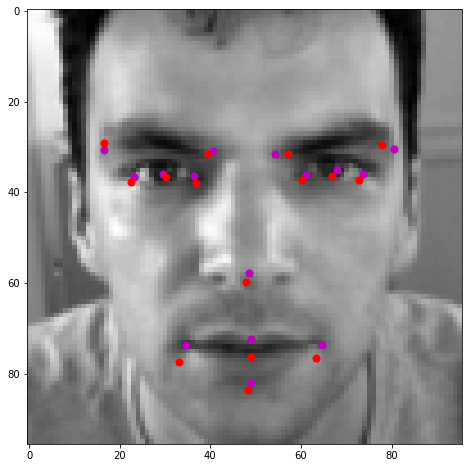

3 224 224
tensor([[ 0.3806, -0.2581],
        [-0.3773, -0.2648],
        [ 0.2575, -0.2378],
        [ 0.4936, -0.2357],
        [-0.2604, -0.2504],
        [-0.4906, -0.2404],
        [ 0.1679, -0.4146],
        [ 0.6212, -0.3927],
        [-0.1648, -0.4166],
        [-0.6490, -0.3833],
        [ 0.0143,  0.1411],
        [ 0.2586,  0.5161],
        [-0.2957,  0.5091],
        [-0.0041,  0.4177],
        [-0.0174,  0.6838]])


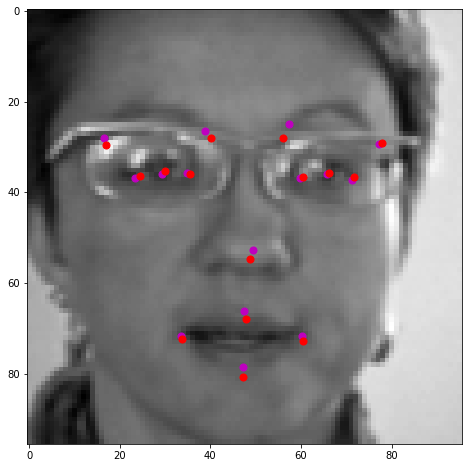

3 224 224
tensor([[ 0.3426, -0.2590],
        [-0.3366, -0.2187],
        [ 0.2204, -0.2416],
        [ 0.4451, -0.2583],
        [-0.2222, -0.2176],
        [-0.4553, -0.2016],
        [ 0.1320, -0.3679],
        [ 0.5354, -0.4140],
        [-0.2157, -0.3184],
        [-0.5892, -0.2774],
        [ 0.0328,  0.1397],
        [ 0.3238,  0.4971],
        [-0.1992,  0.5347],
        [ 0.0398,  0.4449],
        [ 0.0603,  0.6442]])


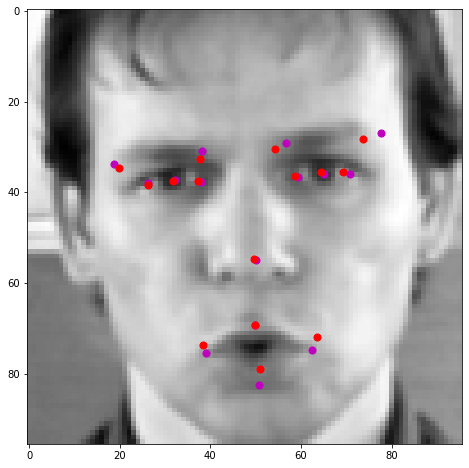

In [29]:
indices = show_keypoint_predictions_test(loaded_model, val_dataset)

In [30]:
def show_all_predicted_keypoints(image, keypoints, pred_kpts=None):
    """Show image with predicted keypoints"""
    #image = (image.clone() * 255).view(96, 96)
    print(image.size())
    plt.figure()
    plt.imshow(preprocess_webcam(image)[0].detach().numpy(), cmap='gray')
    keypoints = keypoints.clone() * 48 + 48
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=200, marker='.', c='m')
    if pred_kpts is not None:
        pred_kpts = pred_kpts.clone() * 48 + 48
        plt.scatter(pred_kpts[:, 0], pred_kpts[:, 1], s=200, marker='.', c='r')
    plt.show()

It seems like the model has overfitted the training set, the validation set was too similar to training set so it was unclear, also, hue shift in webcam did not help, also, the frame[x:x+w, y:y+h] does not give the full face, but the cv2.rectangle with the same coordinates gives correct rectange

In [31]:
preprocess_webcam= transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((96,96)),
  transforms.ToTensor(),
  #transforms.Lambda(lambda x: x.unsqueeze(0))
])   #This is necessary in order to use the pretrained model's feature extractors (Conv. layers)

In [34]:
def mark_custom_image(name, model = loaded_model): #shows the grayscale image captured by us
    image = plt.imread(name)  #read a grayscale jpg as 3 channel image for some reason (each channel same)
    print(image.shape)
    image = image[:,:,0]
    print(image.shape)
    
    plt.figure()
    plt.imshow(image)
    
    image_tensor = preprocess(torch.from_numpy(image))
    #image_tensor = preprocess(image_tensor)
    print(image_tensor.size())
    
    print(image_tensor.min())
    print(image_tensor.max())
    print(image_tensor.mean())
    print(image_tensor.std())
    
    print(image_tensor[0] - image_tensor[1])
    print(image_tensor[1] - image_tensor[2])
    print(image_tensor[2] - image_tensor[0])
    
    #image_tensor += 0.6885
    print('new mean=',image_tensor.mean())
    
    plt.figure()
    plt.imshow(image_tensor[0,:].detach().numpy())   #image that goes into the model
    
    predicted_keypoints = torch.squeeze(model(image_tensor).detach()).view(15,2) #prediction done on this
    print(type(image_tensor))
    show_all_predicted_keypoints(image_tensor[0], predicted_keypoints, predicted_keypoints)

In [36]:
mark_custom_image('my_face.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'my_face.jpg'